In [30]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
# Out Of Memory 문제 방지 (메모리 청소)

tf.keras.backend.clear_session()

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Augmentation 적용한 데이터셋 만들기

In [7]:
from collections import Counter

# Define a function to shuffle with a fixed seed
def shuffle_with_seed(dataset, seed):
    return dataset.shuffle(buffer_size=1000, seed=seed, reshuffle_each_iteration=False)

# Load the dataset
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=False,
    with_info=True
)

# Apply the shuffle function with a fixed seed
RANDOM_SEED = 42
ds_train = shuffle_with_seed(ds_train, RANDOM_SEED)
ds_test = shuffle_with_seed(ds_test, RANDOM_SEED)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


### mixup 구현하기

In [8]:
# num classes 변수 미리 지정
num_classes = ds_info.features["label"].num_classes

In [9]:
# clip box 활용하여 2개의 이미지 섞기
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

In [10]:
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=num_classes):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)    # cutmix 비율 만큼 label mix

    # 원핫 인코딩 처리하기
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_label

In [11]:
# Cutmix 함수 구현

def cutmix(images, labels, img_size=224, batch_size=16, num_classes=num_classes):
    mixed_images = []
    mixed_labels = []

    for i in range(batch_size):
        # 배치에서 각 이미지와 라벨 추출
        image_a = images[i]
        label_a = labels[i]

        # 랜덤 인덱스 생성
        j = tf.random.uniform([], 0, batch_size, dtype=tf.int32)
        image_b = images[j]
        label_b = labels[j]

        # 클리핑 박스 계산
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        mixed_image = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
        mixed_label = mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max)

        # 이미지와 라벨 혼합, 결과 리스트에 추가
        mixed_images.append(mixed_image)
        mixed_labels.append(mixed_label)


    # 배치 크기에 맞게 텐서로 변환
    mixed_images = tf.reshape(tf.stack(mixed_images), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))

    return mixed_images, mixed_labels

In [12]:
# function for mixup
def mixup(image, label, img_size=224, batch_size=16, num_classes=num_classes):

    ratio = tf.random.uniform([], 0, 1)

    mixed_images = []
    mixed_labels = []

    for i in range(batch_size):
        # 배치에서 각 이미지와 라벨 추출
        image_a = image[i]
        label_a = label[i]
        # 랜덤 인덱스 생성
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]

        # 원핫 인코딩 처리하기
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        if len(label_b.shape)==0:
            label_b = tf.one_hot(label_b, num_classes)

        # 비율에 맞게 이미지와 라벨 혼합
        mixed_image= (1-ratio)*image_a + ratio*image_b
        mixed_label = (1-ratio)*label_a + ratio*label_b

        # 결과 리스트에 추가
        mixed_images.append(mixed_image)
        mixed_labels.append(mixed_label)

    # 배치 크기에 맞게 텐서로 변환
    mixed_images = tf.reshape(tf.stack(mixed_images), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))


    return mixed_images, mixed_labels

In [22]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def onehot(image, label):
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label

# 메인함수
def apply_normalize_on_dataset(ds,is_test=False,batch_size=16, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
# augmentation 적용하기
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 2. 모델 만들기

In [15]:
# 4. Mixup 모델

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 3. 모델 학습

일반 데이터셋 모델

In [15]:
EPOCH = 100

Mixup 데이터셋 모델

In [16]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

callbacks=tf.keras.callbacks.ModelCheckpoint(
    'history/mixup_resnet50.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

history_resnet50_mixup100 = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    callbacks=[callbacks],
    verbose=1)

Epoch 1/100
750/750 [==============================] - 199s 211ms/step - loss: 3.6865 - accuracy: 0.2482 - val_loss: 3.6663 - val_accuracy: 0.1735

Epoch 00001: val_loss improved from inf to 3.66626, saving model to history/mixup_resnet50.h5


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
750/750 [==============================] - 158s 210ms/step - loss: 2.7991 - accuracy: 0.5138 - val_loss: 1.6673 - val_accuracy: 0.5479

Epoch 00002: val_loss improved from 3.66626 to 1.66729, saving model to history/mixup_resnet50.h5
Epoch 3/100
750/750 [==============================] - 158s 210ms/step - loss: 2.4867 - accuracy: 0.6328 - val_loss: 1.4343 - val_accuracy: 0.6011

Epoch 00003: val_loss improved from 1.66729 to 1.43433, saving model to history/mixup_resnet50.h5
Epoch 4/100
750/750 [==============================] - 157s 210ms/step - loss: 2.3579 - accuracy: 0.6911 - val_loss: 1.5431 - val_accuracy: 0.5813

Epoch 00004: val_loss did not improve from 1.43433
Epoch 5/100
750/750 [==============================] - 158s 210ms/step - loss: 2.1824 - accuracy: 0.7458 - val_loss: 1.4314 - val_accuracy: 0.6129

Epoch 00005: val_loss improved from 1.43433 to 1.43136, saving model to history/mixup_resnet50.h5
Epoch 6/100
750/750 [==============================] - 157s 210

750/750 [==============================] - 157s 210ms/step - loss: 1.4578 - accuracy: 0.9019 - val_loss: 1.5521 - val_accuracy: 0.6405

Epoch 00042: val_loss did not improve from 1.25075
Epoch 43/100
750/750 [==============================] - 157s 210ms/step - loss: 1.4910 - accuracy: 0.8921 - val_loss: 1.6439 - val_accuracy: 0.6185

Epoch 00043: val_loss did not improve from 1.25075
Epoch 44/100
750/750 [==============================] - 157s 210ms/step - loss: 1.4691 - accuracy: 0.8908 - val_loss: 1.5044 - val_accuracy: 0.6475

Epoch 00044: val_loss did not improve from 1.25075
Epoch 45/100
750/750 [==============================] - 157s 210ms/step - loss: 1.4515 - accuracy: 0.8934 - val_loss: 1.7085 - val_accuracy: 0.6170

Epoch 00045: val_loss did not improve from 1.25075
Epoch 46/100
750/750 [==============================] - 157s 210ms/step - loss: 1.4705 - accuracy: 0.8968 - val_loss: 1.5476 - val_accuracy: 0.6369

Epoch 00046: val_loss did not improve from 1.25075
Epoch 47/100


750/750 [==============================] - 157s 210ms/step - loss: 1.2359 - accuracy: 0.9061 - val_loss: 1.6594 - val_accuracy: 0.6166

Epoch 00083: val_loss did not improve from 1.25075
Epoch 84/100
750/750 [==============================] - 157s 210ms/step - loss: 1.2286 - accuracy: 0.9064 - val_loss: 1.6097 - val_accuracy: 0.6343

Epoch 00084: val_loss did not improve from 1.25075
Epoch 85/100
750/750 [==============================] - 157s 209ms/step - loss: 1.2483 - accuracy: 0.8982 - val_loss: 1.6846 - val_accuracy: 0.6091

Epoch 00085: val_loss did not improve from 1.25075
Epoch 86/100
750/750 [==============================] - 157s 210ms/step - loss: 1.2322 - accuracy: 0.9032 - val_loss: 1.7008 - val_accuracy: 0.6223

Epoch 00087: val_loss did not improve from 1.25075
Epoch 88/100
750/750 [==============================] - 157s 210ms/step - loss: 1.2296 - accuracy: 0.8968 - val_loss: 1.6506 - val_accuracy: 0.6238

Epoch 00088: val_loss did not improve from 1.25075
Epoch 89/100


In [20]:
mixup_resnet50.save_weights('history/mixup_resnet50_100.h5')

학습 후 히스토리 저장하기

In [21]:
import pandas as pd
import json

with open('history/history_resnet50_mixup100.json', 'w') as f:
    pd.DataFrame(history_resnet50_mixup100.history).to_json(f)

In [22]:
def history_conv(history):
    return_history = {'loss' : list(history['loss'].values()),
                      'accuracy' : list(history['accuracy'].values()),
                      'val_loss' : list(history['val_loss'].values()),
                      'val_accuracy' : list(history['val_accuracy'].values())}

    return return_history

In [24]:
# 저장된 히스토리 불러오기
import pandas as pd
import json

with open('history/history_resnet50_mixup100.json', 'r') as f:
    history_resnet50_mixup100 = json.load(f)

history_resnet50_mixup100 = history_conv(history_resnet50_mixup100)

## 4. 시각화 하기

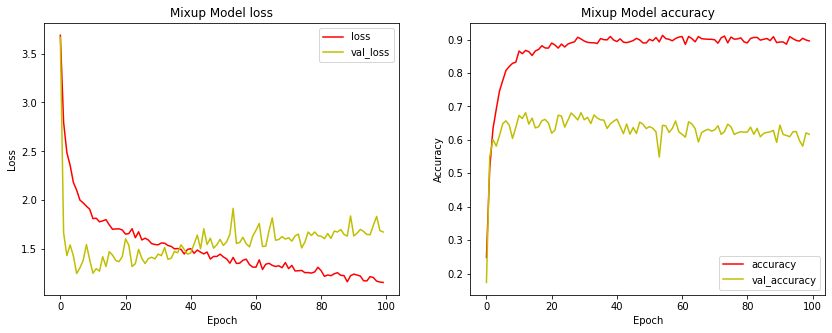

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(history_resnet50_mixup100['loss'], 'r')
plt.plot(history_resnet50_mixup100['val_loss'], 'y')
plt.title('Mixup Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='best')

plt.subplot(122)
plt.plot(history_resnet50_mixup100['accuracy'], 'r')
plt.plot(history_resnet50_mixup100['val_accuracy'], 'y')
plt.title('Mixup Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='best')
plt.show()

## 5. 평가하기

In [96]:
mixup_resnet50.load_weights("history/mixup_resnet50_100.h5")

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [143]:
# Create a dictionary describing the features.
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image

def read_tfrecord(example_proto):
    tfrecord_format = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string)
    }
    
    example = tf.io.parse_single_example(example_proto, tfrecord_format)
    image = decode_image(example["image"])
    label = tf.cast(example["label"], tf.string)
    return image, label

def load_dataset(dataset):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

In [144]:
import os

final_test = tf.data.TFRecordDataset(os.getenv('HOME')+"/aiffel/node_data/GD02/dataset.tfrecord")
test_data = load_dataset(final_test)

In [145]:
test_data

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.string)>

In [152]:
for i, label in enumerate(ds_info.features["label"].names):
    print(f"{i}: {label}")

0: n02085620-chihuahua
1: n02085782-japanese_spaniel
2: n02085936-maltese_dog
3: n02086079-pekinese
4: n02086240-shih-tzu
5: n02086646-blenheim_spaniel
6: n02086910-papillon
7: n02087046-toy_terrier
8: n02087394-rhodesian_ridgeback
9: n02088094-afghan_hound
10: n02088238-basset
11: n02088364-beagle
12: n02088466-bloodhound
13: n02088632-bluetick
14: n02089078-black-and-tan_coonhound
15: n02089867-walker_hound
16: n02089973-english_foxhound
17: n02090379-redbone
18: n02090622-borzoi
19: n02090721-irish_wolfhound
20: n02091032-italian_greyhound
21: n02091134-whippet
22: n02091244-ibizan_hound
23: n02091467-norwegian_elkhound
24: n02091635-otterhound
25: n02091831-saluki
26: n02092002-scottish_deerhound
27: n02092339-weimaraner
28: n02093256-staffordshire_bullterrier
29: n02093428-american_staffordshire_terrier
30: n02093647-bedlington_terrier
31: n02093754-border_terrier
32: n02093859-kerry_blue_terrier
33: n02093991-irish_terrier
34: n02094114-norfolk_terrier
35: n02094258-norwich_terri

In [151]:
for images, labels in test_data.take(10):
    print(labels)

tf.Tensor(b'n02096585-boston_bull', shape=(), dtype=string)
tf.Tensor(b'n02115641-dingo', shape=(), dtype=string)
tf.Tensor(b'n02086079-pekinese', shape=(), dtype=string)
tf.Tensor(b'n02088632-bluetick', shape=(), dtype=string)
tf.Tensor(b'n02099601-golden_retriever', shape=(), dtype=string)
tf.Tensor(b'n02093647-bedlington_terrier', shape=(), dtype=string)
tf.Tensor(b'n02093647-bedlington_terrier', shape=(), dtype=string)
tf.Tensor(b'n02090622-borzoi', shape=(), dtype=string)
tf.Tensor(b'n02110806-basenji', shape=(), dtype=string)
tf.Tensor(b'n02092002-scottish_deerhound', shape=(), dtype=string)


In [121]:
ds_train

<ShuffleDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [126]:
just_train_data = apply_normalize_on_dataset(ds_train,is_test=True,batch_size=16)

In [127]:
just_train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

In [128]:
final_test_data = apply_normalize_on_dataset(test_data,is_test=True,batch_size=16)

In [129]:
final_test_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

In [130]:
mixup_resnet50.evaluate(final_test_data)

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  StringToNumberOp could not correctly convert string: n02096585-boston_bull
	 [[{{node StringToNumber}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) Invalid argument:  StringToNumberOp could not correctly convert string: n02096585-boston_bull
	 [[{{node StringToNumber}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_14826]

Function call stack:
test_function -> test_function
